In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from scipy.fftpack import fft
from sklearn.utils import resample
import os
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
#importing data
from google.colab import files
uploaded = files.upload()

Saving 2005-2022-local-authority-ghg-emissions-csv-dataset.csv to 2005-2022-local-authority-ghg-emissions-csv-dataset.csv


In [8]:
# Load the datasets again
df = pd.read_csv('2005-2022-local-authority-ghg-emissions-csv-dataset.csv')

In [9]:
# Filtering out the Region
yh_df = df[
    (df['Country'] == 'England') &
    (df['Region'] == 'Yorkshire and the Humber') &
    (df['Local Authority'] != 'Unallocated')
]

In [10]:
# Columns to drop
columns_to_drop = [
    'Country', 'Country Code', 'Region Code',
    'Second Tier Authority', 'Local Authority Code',
    'Greenhouse gas'
]

# Drop the unnecessary columns
df1 = yh_df.drop(columns=columns_to_drop)


In [11]:
# Clean up column names by stripping whitespace
df1.columns = df1.columns.str.strip()

# Convert 'Calendar Year' to timestamp
df1['timestamp'] = pd.to_datetime(df1['Calendar Year'], format='%Y')

# Set it as index
df1.set_index('timestamp', inplace=True)


In [12]:
print(df1.columns)

Index(['Region', 'Local Authority', 'Calendar Year', 'LA GHG Sector',
       'LA GHG Sub-sector', 'Territorial emissions (kt CO2e)',
       'CO2 emissions within the scope of influence of LAs (kt CO2)',
       'Mid-year Population (thousands)', 'Area (km2)'],
      dtype='object')


In [13]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Calendar Year,22865.0,2013.483709,5.193745,2005.000000,2009.000000,2013.000000,2018.000000,2022.000000
Territorial emissions (kt CO2e),22865.0,37.675902,218.247020,-447.123117,0.094400,1.275001,12.167545,9574.527472
CO2 emissions within the scope of influence of LAs (kt CO2),22865.0,23.809651,82.830986,0.000000,0.000000,0.000000,0.000000,1055.481287
Mid-year Population (thousands),22865.0,357.599112,176.867101,157.197000,210.021105,303.354218,518.002000,822.483000
Area (km2),22865.0,1046.996103,1964.294146,81.497400,286.534300,366.419800,568.551300,8052.192800


In [20]:
# Data Understanding
print(df1.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22865 entries, 2005-01-01 to 2022-01-01
Data columns (total 9 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Region                                                       22865 non-null  object 
 1   Local Authority                                              22865 non-null  object 
 2   Calendar Year                                                22865 non-null  int64  
 3   LA GHG Sector                                                22865 non-null  object 
 4   LA GHG Sub-sector                                            22865 non-null  object 
 5   Territorial emissions (kt CO2e)                              22865 non-null  float64
 6   CO2 emissions within the scope of influence of LAs (kt CO2)  22865 non-null  float64
 7   Mid-year Population (thousands)                             

In [21]:
print(df1.head())


                              Region              Local Authority  \
timestamp                                                           
2005-01-01  Yorkshire and the Humber  Kingston upon Hull, City of   
2005-01-01  Yorkshire and the Humber  Kingston upon Hull, City of   
2005-01-01  Yorkshire and the Humber  Kingston upon Hull, City of   
2005-01-01  Yorkshire and the Humber  Kingston upon Hull, City of   
2005-01-01  Yorkshire and the Humber  Kingston upon Hull, City of   

            Calendar Year LA GHG Sector        LA GHG Sub-sector  \
timestamp                                                          
2005-01-01           2005   Agriculture  Agriculture Electricity   
2005-01-01           2005   Agriculture  Agriculture Electricity   
2005-01-01           2005   Agriculture  Agriculture Electricity   
2005-01-01           2005   Agriculture          Agriculture Gas   
2005-01-01           2005   Agriculture          Agriculture Gas   

            Territorial emissions (kt C

In [ ]:
print("There are", df1.shape[0], 'rows and', df1.shape[1], "columns.")

There are 22865 rows and 9 columns.


In [22]:
print(df1.describe())


       Calendar Year  Territorial emissions (kt CO2e)  \
count   22865.000000                     22865.000000   
mean     2013.483709                        37.675902   
std         5.193745                       218.247020   
min      2005.000000                      -447.123117   
25%      2009.000000                         0.094400   
50%      2013.000000                         1.275001   
75%      2018.000000                        12.167545   
max      2022.000000                      9574.527472   

       CO2 emissions within the scope of influence of LAs (kt CO2)  \
count                                       22865.000000             
mean                                           23.809651             
std                                            82.830986             
min                                             0.000000             
25%                                             0.000000             
50%                                             0.000000          

In [23]:
print(df1['CO2 emissions within the scope of influence of LAs (kt CO2)'].value_counts())


CO2 emissions within the scope of influence of LAs (kt CO2)
0.000000      17698
56.326634         1
129.967919        1
72.972177         1
9.873645          1
              ...  
0.185598          1
5.539817          1
105.872956        1
139.279599        1
56.408179         1
Name: count, Length: 5168, dtype: int64


In [24]:
print(df1.isnull().sum())
print(f"Number of duplicate rows: {df1.duplicated().sum()}")

Region                                                         0
Local Authority                                                0
Calendar Year                                                  0
LA GHG Sector                                                  0
LA GHG Sub-sector                                              0
Territorial emissions (kt CO2e)                                0
CO2 emissions within the scope of influence of LAs (kt CO2)    0
Mid-year Population (thousands)                                0
Area (km2)                                                     0
dtype: int64
Number of duplicate rows: 0


In [ ]:
# Identifying duplicate rows in the dataset
duplicate_rows = df1.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 0


In [25]:
# Identify columns with more than 50% missing values
missing_threshold = 0.5 * len(df1)
columns_to_drop = [col for col in df1.columns if df1[col].isnull().sum() > missing_threshold]


In [26]:
# Drop columns with excessive missing values
df1.drop(columns=columns_to_drop, inplace=True)


In [27]:
# Fill remaining missing values with median
df1.fillna(df.median(numeric_only=True), inplace=True)


In [28]:
# Verify that missing values are removed
missing_values_final = df1.isnull().sum()
missing_values_final = missing_values_final[missing_values_final > 0]


In [29]:
if missing_values_final.empty:
    print("\n All missing values have been handled successfully!")
else:
    print("\n Some missing values still remain:")
    print(missing_values_final)



 All missing values have been handled successfully!


In [30]:
df1.shape

(22865, 9)

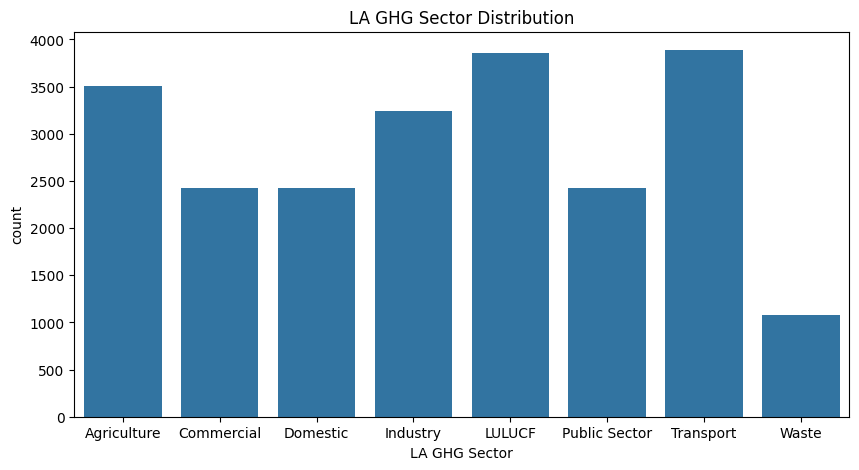

In [31]:
plt.figure(figsize=(10, 5))
sns.countplot(x="LA GHG Sector", data=df1)
plt.title("LA GHG Sector Distribution")
plt.show()


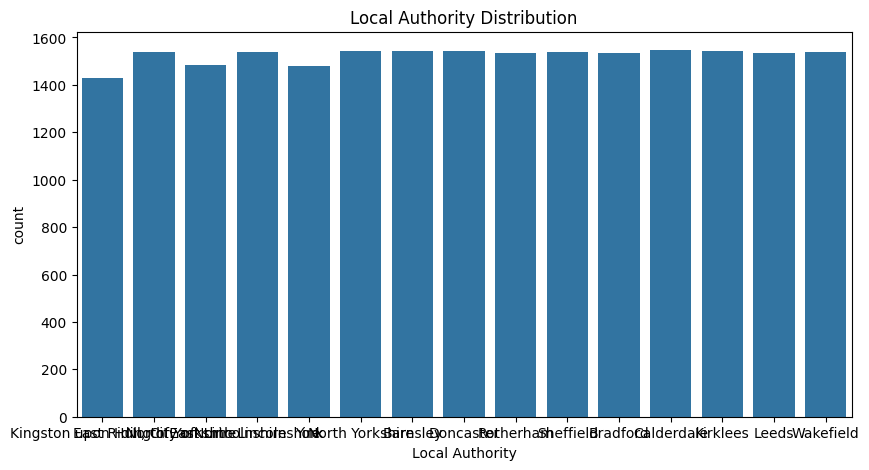

In [32]:
plt.figure(figsize=(10, 5))
sns.countplot(x="Local Authority", data=df1)
plt.title("Local Authority Distribution")
plt.show()


In [33]:
# Clean and set index
df1.columns = df1.columns.str.strip()
df1['timestamp'] = pd.to_datetime(df1['Calendar Year'], format='%Y')
df1.set_index('timestamp', inplace=True)

# Add numeric year column
df1['year'] = df1.index.year

# Split: train = before 2021, test = 2021–2022
train = df1[df1['year'] < 2021]
test = df1[df1['year'] >= 2021]


In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Territorial emissions (kt CO2e)']])
test_scaled = scaler.transform(test[['Territorial emissions (kt CO2e)']])


In [35]:
import numpy as np

window_size = 5

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, window_size)


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=20, batch_size=32,  callbacks=[early_stop],verbose=1)


Epoch 1/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - loss: 5.2013e-04
Epoch 2/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 4.5383e-04
Epoch 3/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 4.9432e-04
Epoch 4/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - loss: 5.6972e-04
Epoch 5/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 4.9284e-04
Epoch 6/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 4.5801e-04
Epoch 7/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 3.3070e-04
Epoch 8/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 3.5667e-04
Epoch 9/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - loss: 3.7804e-04
Epoch 10/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 4.4920e-04
Epoch 11/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 5.1544e-04
Epoch 12/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - loss: 5.7073e-04
Epoch 13/20
10160/10160 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 4.2348e-04
Epoch 14

In [37]:
forecast_input = list(test_scaled[:window_size])
test_preds = []

for _ in range(2):  # Forecast only 2 years
    input_seq = np.array(forecast_input[-window_size:]).reshape(1, window_size, 1)
    pred = model.predict(input_seq, verbose=0)
    test_preds.append(pred[0][0])
    forecast_input.append([pred[0][0]])  # Keep same shape


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Inverse scale
y_pred_test = scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))
# Use only the last 2 rows of test set (2021–2022)
y_true_test = test[['Territorial emissions (kt CO2e)']].iloc[:2].values


# Metrics
mse = mean_squared_error(y_true_test, y_pred_test)
mae = mean_absolute_error(y_true_test, y_pred_test)
r2 = r2_score(y_true_test, y_pred_test)

print(" LSTM Evaluation on 2021–2022 Forecast:")
print(f"• MSE  = {mse:.2f}")
print(f"• MAE  = {mae:.2f}")
print(f"• R²   = {r2:.4f}")


 LSTM Evaluation on 2021–2022 Forecast:
• MSE  = 581.65
• MAE  = 24.12
• R²   = -199108.7533


In [39]:
# Step 1: Start forecast input from 2022 (end of test)
forecast_input = list(train_scaled[-window_size:])  # last 5 values before 2021
forecast_input.append([test_preds[0]])  # 2021
forecast_input.append([test_preds[1]])  # 2022

# Step 2: Forecast 28 future years: 2023–2050
future_preds = []
for _ in range(28):
    input_seq = np.array(forecast_input[-window_size:]).reshape(1, window_size, 1)
    pred = model.predict(input_seq, verbose=0)
    future_preds.append(pred[0][0])
    forecast_input.append([pred[0][0]])  # keep growing the window


In [40]:
# Step 3: Inverse transform
forecast_emissions = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Step 4: Create forecast DataFrame
forecast_years = np.arange(2023, 2051)
forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'Forecasted Emissions (kt CO2e)': forecast_emissions.flatten()
})
forecast_df.set_index('Year', inplace=True)
forecast_df.tail()  # see the last few values


,Forecasted Emissions (kt CO2e)
Year,
2046,24.174633
2047,24.174633
2048,24.174633
2049,24.174633
2050,24.174633


In [42]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
import numpy as np

# Set parameters
window_size = 5
forecast_horizon = 28  # 2023–2050
target_col = 'Territorial emissions (kt CO2e)'
results = []

# Loop through each Local Authority
for authority, group in df1.groupby('Local Authority'):

    try:
        # Step 1: Prepare and sort data
        group = group.sort_values('Calendar Year')
        group['timestamp'] = pd.to_datetime(group['Calendar Year'], format='%Y')
        group.set_index('timestamp', inplace=True)
        series = group[[target_col]].copy()

        if len(series) < window_size + 5:
            continue  # Skip if not enough data

        # Step 2: Scale emissions
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(series)

        # Step 3: Create sequences
        def create_sequences(data, window_size):
            X, y = [], []
            for i in range(len(data) - window_size):
                X.append(data[i:i+window_size])
                y.append(data[i+window_size])
            return np.array(X), np.array(y)

        X, y = create_sequences(scaled_data, window_size)

        # Step 4: Train LSTM
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
        model.add(Dropout(0.2))
        model.add(LSTM(32))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X, y, epochs=20, batch_size=2, callbacks=[early_stop], verbose=0)

        # Step 5: Forecast 28 years ahead from 2022 (use last full sequence)
        forecast_input = list(scaled_data[-window_size:])
        forecast_preds = []

        for _ in range(forecast_horizon):
            input_seq = np.array(forecast_input[-window_size:]).reshape(1, window_size, 1)
            pred = model.predict(input_seq, verbose=0)
            forecast_preds.append(pred[0][0])
            forecast_input.append([pred[0][0]])

        # Step 6: Inverse transform
        forecast_emissions = scaler.inverse_transform(np.array(forecast_preds).reshape(-1, 1))

        # Step 7: Save 2050 value
        emission_2050 = forecast_emissions[-1][0]
        results.append((authority, emission_2050))

    except Exception as e:
        print(f" Skipping {authority}: {e}")
        continue

# Step 8: Create final DataFrame
forecast_2050_df = pd.DataFrame(results, columns=['Local Authority', 'Forecasted Emissions (2050)'])
forecast_2050_df.sort_values(by='Forecasted Emissions (2050)', inplace=True)

# Step 9: Save or display
print(forecast_2050_df.head(10))  # top 10 lowest
forecast_2050_df.to_csv("forecast_2050_per_local_authority.csv", index=False)


                Local Authority  Forecasted Emissions (2050)
2                    Calderdale                    11.238794
14                         York                    11.635858
5   Kingston upon Hull, City of                    18.686510
6                      Kirklees                    19.486065
0                      Barnsley                    20.017633
11                    Rotherham                    23.655542
8       North East Lincolnshire                    24.581568
13                    Wakefield                    28.002855
3                     Doncaster                    28.270054
4      East Riding of Yorkshire                    34.294224


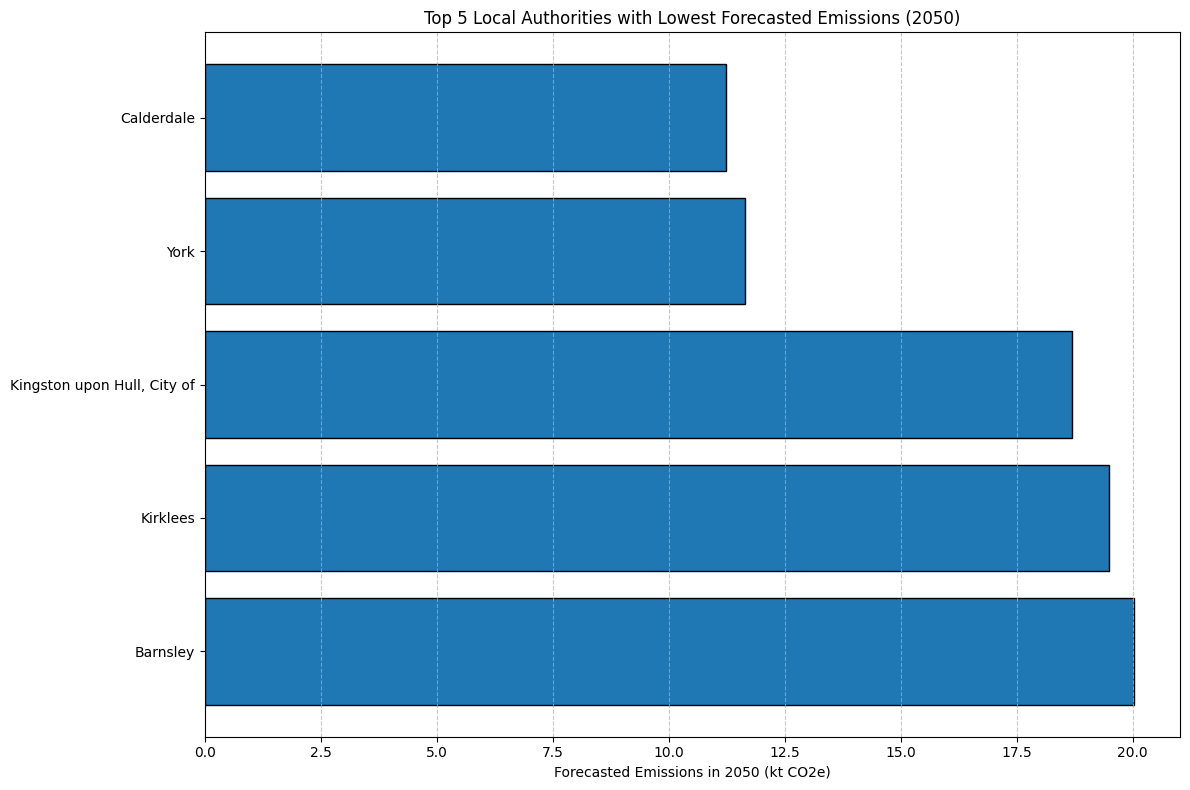

In [80]:
import matplotlib.pyplot as plt

# Sort DataFrame by emissions
sorted_df = forecast_2050_df.sort_values(by='Forecasted Emissions (2050)')

# Optional: select top 10 lowest or highest
top_n = 5
plot_df = sorted_df.head(top_n)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(plot_df['Local Authority'], plot_df['Forecasted Emissions (2050)'], edgecolor='black')
plt.xlabel('Forecasted Emissions in 2050 (kt CO2e)')
plt.title(f'Top {top_n} Local Authorities with Lowest Forecasted Emissions (2050)')
plt.gca().invert_yaxis()  # So the lowest value is at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
